In [50]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import os

## Read in JSON data

In [2]:
!ls

(MoMo data) 2018-01-12-strato-backup.zip
2018-01-12-stato-backup
momo_data_analysis.ipynb


In [3]:
cwd = os.getcwd()

m_raw = pd.read_json(cwd+'/2018-01-12-stato-backup/monitors_1-12-18.json')
r_raw = pd.read_json(cwd+'/2018-01-12-stato-backup/reports_1-12-18.json')

## Examine Reports Data

In [4]:
r_raw.head(3)

,_id,content,data,gateway,monitors_id,received_at,report,status
0,56a07e8f3a18eb2e00bf8f8a,BBn4AjDkqf4muQEA/LgBAAMAAAAI,NaN,http,56a07e8f3a18eb2e00bf8f89,NaT,"{'version': 4, 'batteryVoltage': 4.12656249999...",unknown
1,56a07eda3a18eb2e00bf8f8c,BBn5At1Dgc0BPwAAtD4AAAMAAAAI,NaN,http,56a07eda3a18eb2e00bf8f8b,NaT,"{'version': 4, 'batteryVoltage': 4.1319921875,...",unknown
2,56a07f053a18eb2e00bf8f8e,BBkBA2wv5g6FNwAAMjcAAAMAAAAI,NaN,http,56a07f053a18eb2e00bf8f8d,NaT,"{'version': 4, 'batteryVoltage': 4.17542968749...",unknown


In [5]:
#count non-empty fields
r_raw.count()

_id            1030
content        1030
data            962
gateway        1030
monitors_id    1030
received_at     962
report         1030
status         1030
dtype: int64

### Austin's Notes

**Data Quality**

- Throw out any report without a 'received_at' value. Those should be the only reports with non-integer 'timestamp' values.

- Timestamps under the "report" key should be mostly ignored.  They are relatively consistent (across reports from the same machine) but are not necessarily synchronized with the outside world.

- "report" key is all raw data as received in the text message.  The "data" key has the server-parsed version of the report data, so it should be the same thing as the "entries" in the "report" but with normalized timestamps accounting for clock skew and other things.

- The reports in that archive came from many different generations of monitoring devices.  This means the data will not be consistent across all reports, but should be consistent across reports for a given monitor device UUID.

In [6]:
#drop rows without 'received_at' as per first data point above
r_rec_at = r_raw.dropna(subset=['received_at'])

** Data Description **
- The data.8 key is actually what you might want, and the two values in the tuple are a standard unix timestamp (milliseconds since January 1, 1970) and a sensor reading value.  In your example, this means the sensor read the value "3" on 1/26/2016 at around 9:14am UTC (plus 55 seconds and change).

- 9: This is a baseline sensor reading from which the quartiles were calculated.  It probably doesn't mean much since it is a raw ultrasonic time of flight measurement and dependent on environmental conditions. 

- 10: The number of sensor reading errors (almost always 0, used for diagnostics)

- 11, 12, 13, 14: The number of sensor readings in the 1st, 2nd, 3rd, and 4th quartile, respectively.  Unfortunately I can't recall and don't have source code to reference to determine the interval for these quartiles or how they were calculated from the baseline value.  The sum of streams 11, 12, 13, and 14 for a given timestamp should always be about 360 since there are (give or take 1) 360 readings per interval.  If all four buckets are 0 then the sensor was probably malfunctioning and the sensor wasn't reporting any values to the controller unit.

- To use these bucketed values, qualitatively you can think of it this way - if all 360 ticks were in bucket 11 (first quartile) then there was no (or negligible) water flowing through the pipe for the entirety of a given interval.  Any non-zero value in buckets 12, 13, or 14 means that for that interval there were several ticks during which some volume of water flow was detected.  The higher buckets mean faster flow. For a given report there should be 24 intervals, so 24 values in streams 11, 12, 13, and 14.  The timestamp for these readings indicate when the sensor reported that value, and the 360 readings occurred at evenly spaced increments before that timestamp.

** Data Dictionary**

_id - A unique ID for the report, generated by the server  
gateway - How the report was received (usually HTTP for later-model monitors since we moved from SMS to direct GPRS HTTP requests)  
content - The raw data received by the gateway, this is the base64-encoded report.  
received_at - The timestamp of receipt by the server, milliseconds since 1970  
monitors_id - The globally unique ID of the monitor associated with this report  
report - The parsed report.  This contains the same data as the base64-encoded content and the data key, and reflects exactly what is in the report without any normalization or modification. (sub-keys are version, batteryVoltage, uuid, timestamp, and entries, an array of readings)  
data - The parsed and normalized sensor streams in this report.  Each sub-key is a stream and each sub-value is an array of (timestamp, value) tuples.  
data.battery - The timestamped battery voltage received with this report  
data.9 - The timestamped baseline ultrasound time-of-flight values  
data.10 - The timestamped sensor error counts  
data.11/12/13/14 - The timestamped sensor bucket counts (see above)  

In [7]:
#sample from "data" column containing arrays of tuples for each key 8-14, use 8 and 11-14 for now
r_rec_at.data[269]

{'8': [[1454144756670, 3]],
 '9': [[1454144746669, 4506],
  [1454148346937, 4512],
  [1454151947206, 4512],
  [1454155547474, 4512],
  [1454159147742, 4523],
  [1454162748010, 4511],
  [1454166348279, 4493],
  [1454169948547, 4488],
  [1454173548815, 4486],
  [1454177149083, 4486],
  [1454180749352, 4487],
  [1454184349620, 4488],
  [1454187949888, 4488],
  [1454191550157, 4488],
  [1454195150425, 4488],
  [1454198750693, 4488],
  [1454202350961, 4486],
  [1454205951230, 4486],
  [1454209551498, 4486],
  [1454213151766, 4486],
  [1454216752035, 4485],
  [1454220352303, 4486],
  [1454223952571, 4485],
  [1454227552839, 4485]],
 '10': [[1454148336937, 0],
  [1454151937205, 0],
  [1454155537473, 0],
  [1454159137741, 0],
  [1454162738010, 0],
  [1454166338278, 0],
  [1454169938546, 0],
  [1454173538814, 0],
  [1454177139083, 0],
  [1454180739351, 0],
  [1454184339619, 0],
  [1454187939888, 0],
  [1454191540156, 0],
  [1454195140424, 0],
  [1454198740692, 0],
  [1454202340961, 0],
  [14542

In [8]:
#extract device id, and streams 8,9, 11-14
ids = r_rec_at['monitors_id']
sensor_reading = r_rec_at.data.apply(lambda x: x.get('8'))
quartile_baseline = r_rec_at.data.apply(lambda x: x.get('9'))
q1 = r_rec_at.data.apply(lambda x: x.get('11'))
q2 = r_rec_at.data.apply(lambda x: x.get('12'))
q3 = r_rec_at.data.apply(lambda x: x.get('13'))
q4 = r_rec_at.data.apply(lambda x: x.get('14'))

In [10]:
#put stream data in new dataframe for convenience
data_df = pd.concat([ids, sensor_reading, quartile_baseline,
                     q1, q2, q3, q4], 
                    axis=1)

In [11]:
#rename columns, 8: reading, 9: baseline_9, 11-14:q1_count - q4_count
data_df.columns = ['id','reading_8','baseline_9','q1','q2','q3','q4']

In [12]:
data_df.head(3)

,id,reading_8,baseline_9,q1,q2,q3,q4
68,56a0834d3a18eb2e00bf8fad,"[[1453778596300, 3]]",None,None,None,None,None
69,56a0834d3a18eb2e00bf8fad,"[[1453779744274, 3]]",None,None,None,None,None
70,56a0834d3a18eb2e00bf8fad,"[[1453780201064, 3]]",None,None,None,None,None


In [13]:
#count fields
data_df.count()

id            962
reading_8     301
baseline_9    616
q1            750
q2            750
q3            750
q4            747
dtype: int64

In [14]:
#number of unique devices
data_df.id.unique().size

48

In [18]:
#For all rows with stream 8 present, find distribution of values
data_df.reading_8.dropna().map(lambda x: x[0][1]).value_counts()

3    168
0    133
Name: reading_8, dtype: int64

### Restrict to rows with all columns present

In [24]:
data_df.dropna().count()

id            89
reading_8     89
baseline_9    89
q1            89
q2            89
q3            89
q4            89
dtype: int64

In [26]:
#num unique device ids
data_df.dropna().id.unique().size

46

**So from above, 89 data rows for 46 devices**

In [28]:
#get distribution of number of reports per device
data_df.dropna().id.value_counts().value_counts()

1    20
2    14
3     8
4     3
5     1
Name: id, dtype: int64

From above, we see most devices have 1 or 2 reports (34 total), but 4 devices have 4 or 5 reports total. Let's look at these ones first

In [31]:
#get ids of devices and their report counts
data_df.dropna().id.value_counts().head()

56a084cd3a18eb2e00bf8fb9    5
56a080443a18eb2e00bf8fa3    4
56a0803e3a18eb2e00bf8fa1    4
56a086e13a18eb2e00bf8fe8    4
56a0866d3a18eb2e00bf8fdf    3
Name: id, dtype: int64

Using the top listed device as a sample:

In [35]:
single_device_data = data_df[data_df.id=='56a084cd3a18eb2e00bf8fb9'].dropna()

In [55]:
single_device_data

,id,reading_8,baseline_9,q1,q2,q3,q4
152,56a084cd3a18eb2e00bf8fb9,"[[1453901295071, 0]]","[[1453901285070, 4202], [1453901335074, 4263],...","[[1453904875360, 0], [1453908475651, 0], [1453...","[[1453904875360, 0], [1453908475651, 0], [1453...","[[1453904875360, 0], [1453908475651, 0], [1453...","[[1453904875360, 0], [1453908475651, 0], [1453..."
194,56a084cd3a18eb2e00bf8fb9,"[[1454037939666, 3]]","[[1454037929665, 4478], [1454037959667, 4270],...","[[1454041519911, 290], [1454045120157, 247], [...","[[1454041519911, 3], [1454045120157, 111], [14...","[[1454041519911, 0], [1454045120157, 0], [1454...","[[1454041519911, 0], [1454045120157, 0], [1454..."
655,56a084cd3a18eb2e00bf8fb9,"[[1471264514665, 0]]","[[1471264504522, 4037], [1471268155805, 4268],...","[[1471268145662, 0], [1471271796945, 0], [1471...","[[1471268145662, 0], [1471271796945, 18], [147...","[[1471268145662, 0], [1471271796945, 136], [14...","[[1471268145662, 0], [1471271796945, 165], [14..."
888,56a084cd3a18eb2e00bf8fb9,"[[1481112551802, 0]]","[[1481112541667, 3837], [1481116190230, 4093],...","[[1481116180095, 3], [1481119828658, 23], [148...","[[1481116180095, 1], [1481119828658, 16], [148...","[[1481116180095, 0], [1481119828658, 13], [148...","[[1481116180095, 0], [1481119828658, 15], [148..."
922,56a084cd3a18eb2e00bf8fb9,"[[1487149562188, 0]]","[[1487149552187, 4294], [1487153152555, 4902],...","[[1487153142554, 166], [1487156742923, 0], [14...","[[1487153142554, 67], [1487156742923, 0], [148...","[[1487153142554, 36], [1487156742923, 0], [148...","[[1487153142554, 19], [1487156742923, 0], [148..."


Below: For this particular device, there are 5 reports; 4 have 23 elements in the timeseries and 1 has 47.

In [51]:
#get length of each timeseries array
single_device_data.applymap(lambda x: len(x))

,id,reading_8,baseline_9,q1,q2,q3,q4
152,24,1,7,23,23,23,23
194,24,1,28,23,23,23,23
655,24,1,24,23,23,23,23
888,24,1,48,47,47,47,47
922,24,1,24,23,23,23,23


I think the dates below are when the device received a report? I am using stream 8 and parsing the dates for each row of data

In [49]:
#convert timestamps from stream 8 to dates
single_device_data.reading_8.map(lambda x: pd.to_datetime(x[0][0], unit='ms'))

152   2016-01-27 13:28:15.071
194   2016-01-29 03:25:39.666
655   2016-08-15 12:35:14.665
888   2016-12-07 12:09:11.802
922   2017-02-15 09:06:02.188
Name: reading_8, dtype: datetime64[ns]

### Convert 1 row (report) of device data to new dataframe with timestamp, flow level data

In [81]:
single_row['q1'][:5]

[[1453904875360, 0],
 [1453908475651, 0],
 [1453912075942, 0],
 [1453915676233, 0],
 [1453919276524, 0]]

The cell below extracts the nested timeseries array from each stream column and puts it in a new dataframe for plotting and further processing.

In [110]:
#get one row/day of device data, in this case row 655 from above, 2016-08-15 12:35:14.665
single_row = single_device_data.loc[655]

#extract quartile stream data from nested arrays into new dataframe for plotting
plot_df = pd.DataFrame()
plot_df['datetime'] = [pd.to_datetime(i[0],unit='ms') for i in single_row.q1]

for col in ['q1','q2','q3','q4']:
    plot_df[col] = [i[1] for i in single_row[col]]
    
plot_df = plot_df.set_index('datetime')
plot_df.head()

,q1,q2,q3,q4
datetime,,,,
2016-08-15 13:35:45.662,0,0,0,0
2016-08-15 14:36:36.945,0,18,136,165
2016-08-15 15:37:28.227,8,109,159,47
2016-08-15 16:38:19.509,37,145,81,42
2016-08-15 17:39:10.791,44,185,74,42


**AUSTIN Question: **  
In theory, the sum of q1 to q4 in each of these rows should be 360 (see below)?  
If not what are reasons?

In [112]:
plot_df.sum(axis=1)

datetime
2016-08-15 13:35:45.662      0
2016-08-15 14:36:36.945    319
2016-08-15 15:37:28.227    323
2016-08-15 16:38:19.509    305
2016-08-15 17:39:10.791    345
2016-08-15 18:40:02.074    196
2016-08-15 19:40:53.356    273
2016-08-15 20:41:44.638    360
2016-08-15 21:42:35.921     84
2016-08-15 22:43:27.203    106
2016-08-15 23:44:18.485    302
2016-08-16 00:45:09.767    350
2016-08-16 01:46:01.050    360
2016-08-16 02:46:52.332    173
2016-08-16 03:47:43.614      0
2016-08-16 04:48:34.897    337
2016-08-16 05:49:26.179    269
2016-08-16 06:50:17.461    289
2016-08-16 07:51:08.743    143
2016-08-16 08:52:00.026    204
2016-08-16 09:52:51.308      8
2016-08-16 10:53:42.590    135
2016-08-16 11:54:33.873    112
dtype: int64

### Plot one report for one device

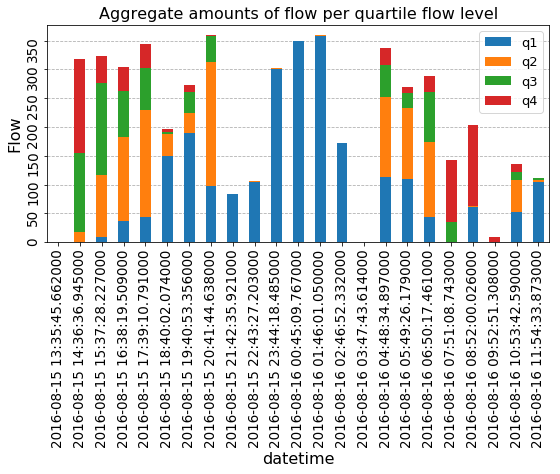

In [121]:
#use pandas for easy plotting, get axes
ax = plot_df.plot.bar(stacked=True, figsize=(9,4)) 

#labels and fonts
# ax.set_xlabel('date')
ax.set_ylabel('Flow')
ax.set_title('Aggregate amounts of flow per quartile flow level',fontsize=16)

ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)

ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)

ax.axes.tick_params(labelsize=13.5, labelrotation=90)

ax.legend(fontsize=13)

**The color scheme, labeling, and titles can definitely be improved above :)**
**AUSTIN please improve below**  
The plot above can already answer many questions about usage at a particular pump location for a single day:
- We can see high usage in the late afternoon and early mornings

## Single device, multiple reports

**AUSTIN** 
In order to to plot multiple flow level reports per device, I think we need to take data from stream 8 and/or 9 in order to normalize data from streams 11-14 to get numerical amounts of flows. Then we can make line graphs of a flow amount per unit time, instead of stacked barplots above.

Since I'm not sure exactly how to relate streams 8,9 and 11-14, I choose to assign a number 1-4 to each quartile and multiply each of those numbers by the aggregated flow times from each data stream. So if there is a data point for quartile 4 for showing 80 ticks of flow, I map that to 80x4=320. The barplot above then looks like:

In [148]:
plot_df.head(3)

,q1,q2,q3,q4
datetime,,,,
2016-08-15 13:35:45.662,0,0,0,0
2016-08-15 14:36:36.945,0,18,136,165
2016-08-15 15:37:28.227,8,109,159,47


In [132]:
#convert data from each row (4 col entries) to a single number representing total flow
#so q1*1 + q2*2 +...
plot_df.apply(lambda x: sum([(i+1)*x.iloc[i] for i in range(plot_df.columns.size)]), axis=1).head()

datetime
2016-08-15 13:35:45.662       0
2016-08-15 14:36:36.945    1104
2016-08-15 15:37:28.227     891
2016-08-15 16:38:19.509     738
2016-08-15 17:39:10.791     804
dtype: int64

In [168]:
x[0]

Timestamp('2016-08-15 13:35:45.662000')

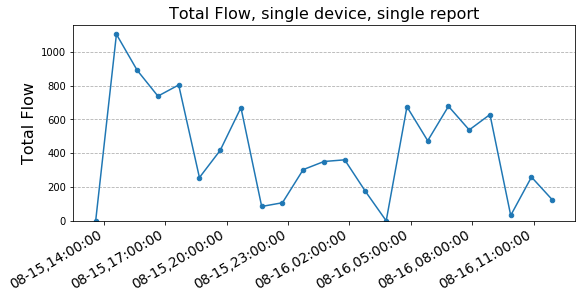

In [174]:
import matplotlib.dates as mdates

#use pandas for easy plotting, get axes
tot_flow_df = plot_df.apply(lambda x: sum([(i+1)*x.iloc[i] for i in range(plot_df.columns.size)]), axis=1)

#change to matplotlib for plotting for more control
fig, ax = plt.subplots(figsize=(9,4))

x = tot_flow_df.index
y = tot_flow_df.values

ax.plot(x,y,'.-',ms=9) 

ax.set_ylim(bottom=.1)

#labels and fonts
# ax.set_xlabel('Material')
ax.set_ylabel('Total Flow')
ax.set_title('Total Flow, single device, single report',fontsize=16)

ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)

ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)

ax.xaxis.set_tick_params(labelsize=13.5)

myFmt = mdates.DateFormatter('%m-%d,%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)

fig.autofmt_xdate()

# ax.legend(fontsize=13)

- This is the same data as the stacked barplot above
- Not sure what's going on with the rounding of the datetimes above on the xaxis, but you get the point

## Many reports, single device

**AUSTIN**:  

We can calculate useful stats related to:
- typical usage over the course of a day
- anomalous days for this device

We can make high level statements and answer big questions like:  
- this device...

Combining the code from above (prob not well:), starting with data for all devices with columns present:

In [180]:
data_all_columns = data_df.dropna()

In [184]:
data_all_columns.head(2)

,id,reading_8,baseline_9,q1,q2,q3,q4
109,56a07f053a18eb2e00bf8f8d,"[[1453866143101, 3]]","[[1453866133100, 4450], [1453869733468, 4456]]","[[1453869723467, 358]]","[[1453869723467, 1]]","[[1453869723467, 0]]","[[1453869723467, 0]]"
110,56a07f133a18eb2e00bf8f8f,"[[1453866363038, 3]]","[[1453866353038, 4579], [1453869953091, 4695]]","[[1453869943090, 0]]","[[1453869943090, 0]]","[[1453869943090, 0]]","[[1453869943090, 0]]"


Methods to extract arrays from columns above

In [185]:
#method to extract timestamp array from column 'q1'
def get_ts_array(row):
    return [pd.to_datetime(i[0],unit='ms') for i in row['q1']]
#can add extraction methods for 'reading_8' and 'baseline_9'

In [196]:
def get_quartile_array(row,col):
    return [i[1] for i in row[col]]

In [249]:
def get_total_flow(row):
    #for each column in row, get array -> convert to numpy array -> mult by numerical quartile equivalent 
    #->sum all 4 arrays element wise for total flow per timestamp
    return np.array(row['q1']) + 2*np.array(row['q2']) + 3*np.array(row['q3']) + 4*np.array(row['q4']) 

Make new dataframe

In [250]:
#define new dataframe to hold extracted timeseries for each device ID
data_streams_df = pd.DataFrame()
#get id column
data_streams_df['id'] = data_all_columns['id']
#get timestamp array
data_streams_df['ts'] = data_all_columns.apply(get_ts_array, axis=1)
#get quartile arrays
for col in ['q1','q2','q3','q4']:
    data_streams_df[col] = data_all_columns.apply(lambda x: get_quartile_array(x,col), axis=1)
#calculate total flow number, TODO: use stream 8 and 9 to do this correctly
data_streams_df['total'] = data_streams_df.apply(get_total_flow, axis=1)

Check that the 'total' column is correct for a single device

In [291]:
#check sum works out
data_streams_df[data_streams_df['id']=='56a084cd3a18eb2e00bf8fb9'].iloc[0]

id                                56a084cd3a18eb2e00bf8fb9
ts       [2016-01-27 14:27:55.360000, 2016-01-27 15:27:...
q1       [0, 0, 0, 0, 0, 0, 0, 76, 89, 90, 90, 87, 22, ...
q2       [0, 0, 0, 0, 1, 90, 90, 14, 1, 0, 0, 0, 1, 0, ...
q3       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
q4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
total    [0, 0, 0, 0, 5, 180, 180, 104, 91, 90, 90, 87,...
Name: 152, dtype: object

In [252]:
#confirm 46 devices
data_streams_df.id.unique().size

46

In [253]:
data_streams_df.id.value_counts().head()

56a084cd3a18eb2e00bf8fb9    5
56a080443a18eb2e00bf8fa3    4
56a0803e3a18eb2e00bf8fa1    4
56a086e13a18eb2e00bf8fe8    4
56a0866d3a18eb2e00bf8fdf    3
Name: id, dtype: int64

**Plot total flows for all reports for a single device**

Remove dates and just plot vs time to compare across days.

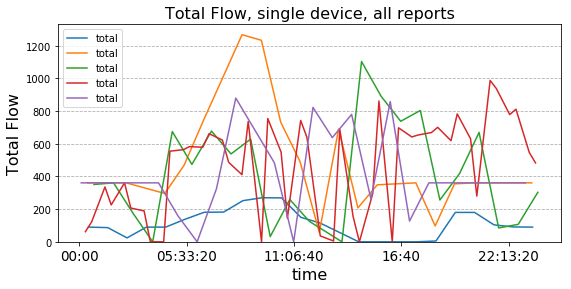

In [354]:
#get single device data
single_device = data_streams_df[data_streams_df['id']=='56a084cd3a18eb2e00bf8fb9']

#define figure and axes
fig, ax = plt.subplots(figsize=(9,4))

#iterate over all reports for one device
for i in range(single_device.id.count()):

    report = single_device.iloc[i]

    #get time from timestamps since we want to compare across different dates
    times = pd.Series(report['ts']).map(lambda x: x.time())
#     print(times)

    #put times, total data into new dataframe
    plt_df = pd.DataFrame({'total':report['total']}, index=times)

    #plot using pandas dataframe plot method, this seems to not cause any date errors
    plt_df.plot(ax=ax) 

ax.set_ylim(bottom=.1)

#labels and fonts
# ax.set_xlabel('Material')
ax.set_ylabel('Total Flow')
ax.set_title('Total Flow, single device, all reports',fontsize=16)

ax.grid(axis='y', linestyle='--')
ax.set_axisbelow(True)

ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)

ax.xaxis.set_tick_params(labelsize=13.5)

#don't use this code for date formatting when pandas is used for plotting
#this would be used when matplotlib controls the axes
# myFmt = mdates.DateFormatter('%H:%M:%S')
# ax.xaxis.set_major_formatter(myFmt)
# fig.autofmt_xdate()

# ax.legend(fontsize=13)

## Many devices, many reports

**AUSTIN**:  

We can calculate useful stats related to:
- typical usage over days, weeks in a region where devices are concentrated
- differences in usage by location corresponding to each device

We can make high level statements and answer big questions like:  
- e.g. these devices show high usage in the mornings, these in the evenings. That's because people in that area etc...

**Battery Voltage**

Battery voltage is reported in Volts.  The nominal voltage of a fully-charged lithium ion battery is around 3.8V.  The voltage should be around 3.8 unless the battery is almost 100% or almost 0% charged, at which points the voltage quickly increases (around 100% charge) or decreases (around 0% charge).  See the below voltage graph for Li-On batteries.  Basically, if the voltage reading is at or above 3.7ish volts then the battery has a good amount of capacity left.  If it is less than 3.7V it means the battery will fail imminently.  The later-model MoMo units did not have an external solar charger, so you should be able to see voltage degradation over time.  Models with an external charge source would stay nearly fully-charged around 4V unless something malfunctioned (for instance, the solar panel might have been stolen or obstructed).

**Number of Sensor Readings per Quantile**  
**Timestamps**  
**Battery Voltage**

In [22]:
r_raw.report[0]

{'version': 4,
 'batteryVoltage': 4.126562499999999,
 'uuid': 4272546864,
 'timestamp': '2000-01-02T07:22:14.000Z',
 'entries': [{'timestamp': '2000-01-02T07:21:32.000Z',
   'value': 3,
   'streamID': 8}]}

In [27]:
r_raw.data.dropna()[68]

{'8': [[1453778596300, 3]], 'battery': [[1453778632300, 4.028828124999999]]}

## Monitor Data

In [18]:
m_raw.head()

,_id,last_report_time,last_report_timestamp,location,name,status,uuid
0,56a07e8f3a18eb2e00bf8f89,2016-08-25 17:07:55.079,777633.0,"[0, 0]",MSABI #01 (LIVE),unknown,4272546864
1,56a07eda3a18eb2e00bf8f8b,NaT,NaN,"[0, 0]",MSABI #04 (DEAD),unknown,3447800797
2,56a07f053a18eb2e00bf8f8d,2016-01-28 03:42:40.168,607901.0,"[0, 0]",MSABI #07 (LIVE),unknown,249966444
3,56a07f133a18eb2e00bf8f8f,2016-08-20 12:05:21.175,432022.0,"[0, 0]",MSABI #08 (LIVE),unknown,3266165150
4,56a07f2b3a18eb2e00bf8f91,2016-02-10 12:28:11.590,1128401.0,"[0, 0]",MSABI #09,unknown,1763173377


In [17]:
m_raw.count()

_id                      50
last_report_time         48
last_report_timestamp    48
location                 50
name                     50
status                   50
uuid                     50
dtype: int64